This example gives the demonstration of the usage of `Pipe` and `Pipenet`, which are used to comstruct higher order analysis procedures.

Thie example includes:
- Initiatie operators of different steps;
- Define the pipe and its usage;
- Define the pipenet using Flow.

First, we import some util modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gamut import SimulatedSpectrum as SimulatedSpectrum, simuspecs, Flow
from gamut import Pipe, PipeNet

import gamut.operators.Smoother as Smoother
import gamut.operators.PeakSearcher as PeakSearcher
import gamut.operators.AreaCalculator as AreaCalculator
import gamut.operators.OtherOperator as OtherOperator
import gamut.operators.BasicOperator as BasicOperator

Here, we use a simulated spectrum for the demonstration. We generate it using the pre-defined parameter combinations in `gamut.simuspecs`.

Use `print(simuspecs.keys())` to have a view on all pre-defined simulated spectra.

dict_keys(['simple', 'double_slight', 'double_normal_narrow', 'double_normal', 'double_severe', 'synthesized', 'synthesized_2', 'single_peaks', 'single_peaks_bigger', 'single_peaks_biggest'])


<Axes: >

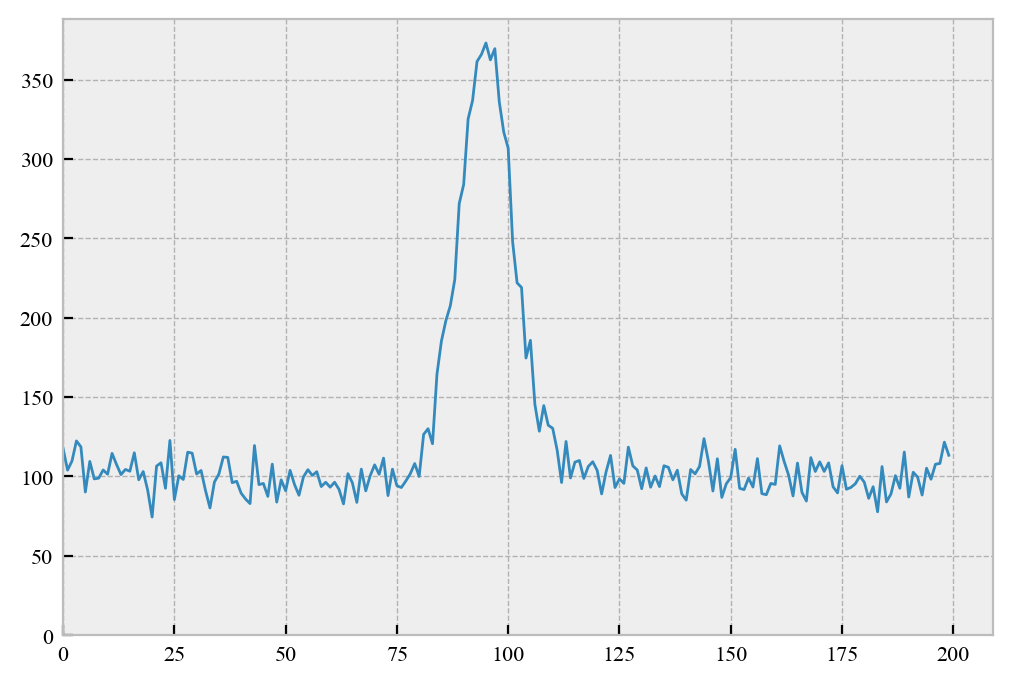

In [2]:
print(simuspecs.keys())
simulated = SimulatedSpectrum(**simuspecs['simple'])
simulated.plot()

We define some basic operators, we have seem them in the previous example. The most basic method to use them is discussed in example_1.ipynb. 

In [35]:
cen = Smoother.CentroidSmoother(order=2)
strip = OtherOperator.SNIPStripper(order=20)
gauss = PeakSearcher.GaussPeakSearcher(order=2, threshold=0.4)
cal = AreaCalculator.AverageClassicPeakAreaCalculator(times=3)

Among them, only the `PeakSearcher` and `AreaCalculator` are obligatory for our analysis. So we consider if the performance is satisfactory without `Smoother` and `Stripper`.


These two operators both accept only one spectrum as input and must be executed in sequence. This is the common case for most operators in Gamut - only one input. So it is natural to use the output of one operator as the input oprator.

For this purpose, `Pipe` is used to concatenate operators and manage their running in order.

In [36]:
main_pipe = Pipe([gauss, cal])

main_pipe

Pipe[Pipe]
 |InpNum: 1
 |Operators: GaussPeakSearcher[O2]>>FPAreaCalculator[T3]

`Pipe` is a subclass of `Opertor`, so it works just like an ordinary operator, except a few special features.

We can output the output spectrum by each of its internal opertors from the pipe, yet it is not frequent since `Pipe` is aimed at reducing the attention paid to seperate operators and it is advisable to seperate the spectrum data and the operators. It can be seen that the name of output spectrum by cal is renamed with the label of the pipe.

In [37]:
out = main_pipe([simulated])
main_pipe.spectra[0].label, main_pipe.spectra[1].label, out.label

('simple|GaussPeakSearcher[O2]', 'simple>>Pipe|Pipe', 'simple>>Pipe|Pipe')

(<Axes: >, <Axes: >)

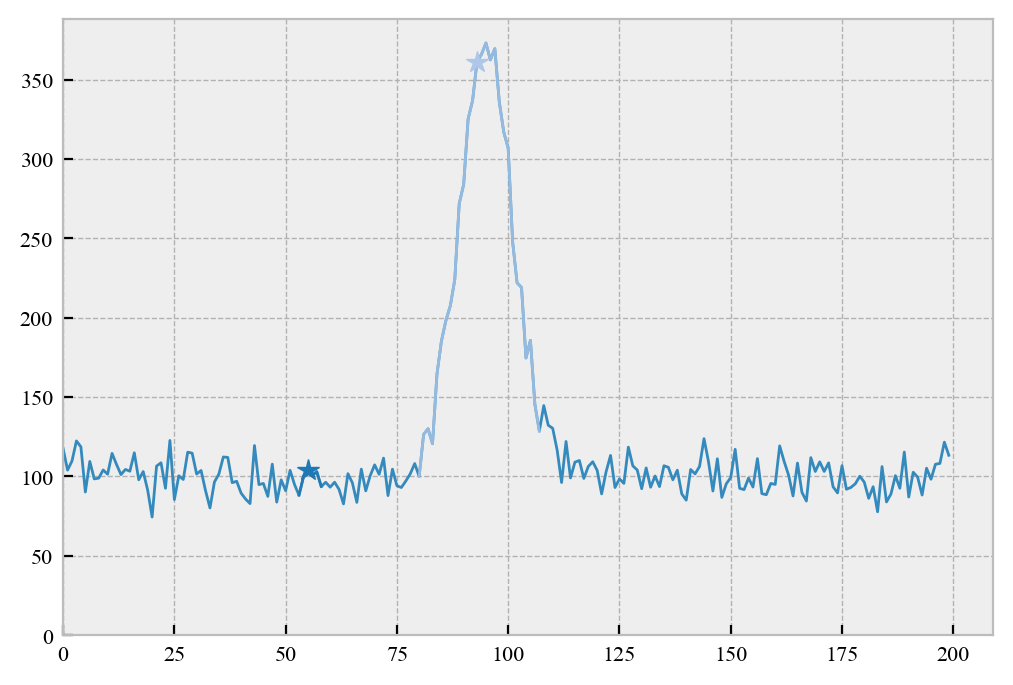

In [38]:
out.export_to_xml("results_example_2.xml")
# <peak location="93" FParea="3419.64" energy="93.00"/>
out.plot(), out.plot_regions()

The calculate peak area is 3457, with relative error=14.5%. The main reason causing such big error is that the right peak boudary is wrongly determined because of the large fluctuation in the spectrum.

Then, we warp a smoother into a pipe and add the main_pipe at its bottom to smooth the spectrum. 

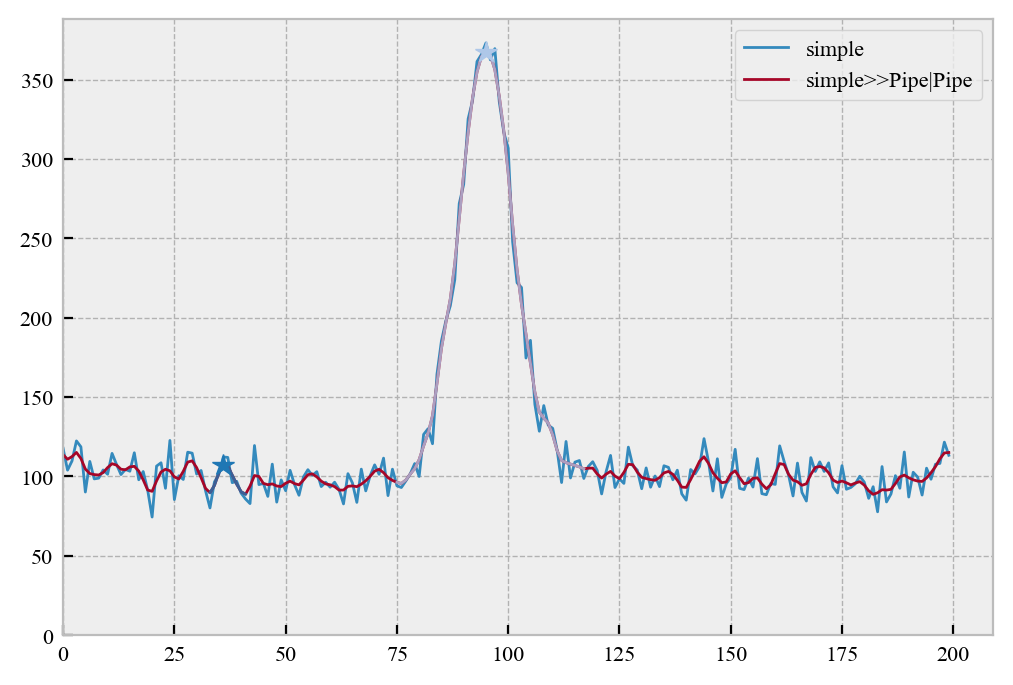

In [39]:
smooth_pipe = Pipe([cen])
smooth_pipe.append(main_pipe)
out = smooth_pipe([simulated])
out.export_to_xml("results_example_2_pipe.xml")
# <peak location="95" FParea="4087.16" energy="95.00"/>

simulated.plot()
out.plot()
out.plot_regions()
plt.legend()

After adding the smoothing pipe, the calculated peak area becomes 4087, with relative error=2.2%.

Then, we can consider the usage of `PipeNet`, it is used when not all operators are linear, as it is in `Pipe`. PipeNet can concatenate opeators and pipes with multiple input.

Before defining the pipenet, we need to wrap all operators and pipes into `Flow`s. Essentially, there is no modification on them, and we only add labels to them to represent the positional information of their input and output.

`Node` is a list to store `Spectrum`, and we need to fill the `Pipenet` with `Operator`s, and then `Pipenet` can generate `Node`s automatically. And `Operator`s will accept `Spectrum` from an input `Node`, and feed its output `Spectrum` to an output `Node`. 

We use a namedtuple `Flow` consisting of the pipe, and input node id, input node order, output node id, and output node order, to represent the complete information for operators. For example, `Flow(cen, 0, [0], 1, 0)` means `cen` read the first spectrum in the Node 0 and produce a spectrum to the first place in the Node 1.

Since any operators generate only 1 spectrum as output, output node order is always an integer, yet the input node order should be a list of integers. For example, `Flow(minus, 2, [0, 1], 3, 0)` means the minus accept the first and the second spectra in the Node 2. Note that `Flow(minus, 2, [0, 1], 3, 0)` is different from `Flow(minus, 2, [1, 0], 3, 0)`.

In [40]:
scheme_smooth_pipe = Flow(cen, 0, [0], 1, 0)
scheme_origin = Flow(BasicOperator.Passer(), 1, [0], 2, 0)
scheme_strip = Flow(strip, 1, [0], 2, 1)
scheme_main_pipe = Flow(Pipe([gauss, cal]), 3, [0], 4, 0)


Here, we define a operator that is a little special. It requires two spectra as input and it minueses the second from the first spectrum. And we define its flow accordingly.

In [41]:
minus = BasicOperator.Stripper()
scheme_minus = Flow(minus, 2, [0, 1], 3, 0)

pipenet = PipeNet([scheme_smooth_pipe, scheme_origin, scheme_strip, scheme_minus, scheme_main_pipe])
pipenet([simulated])

GAMUT: Start running PipeNet
|Execute: Node 0|[0] >> CentroidSmoother[O2] >> Node 1|[0]
|Execute: Node 1|[0] >> Passer >> Node 2|[0]
|Execute: Node 1|[0] >> SNIPStripper >> Node 2|[1]
|Execute: Node 2|[0, 1] >> Stripper >> Node 3|[0]
|Execute: Node 3|[0] >> Pipe >> Node 4|[0]


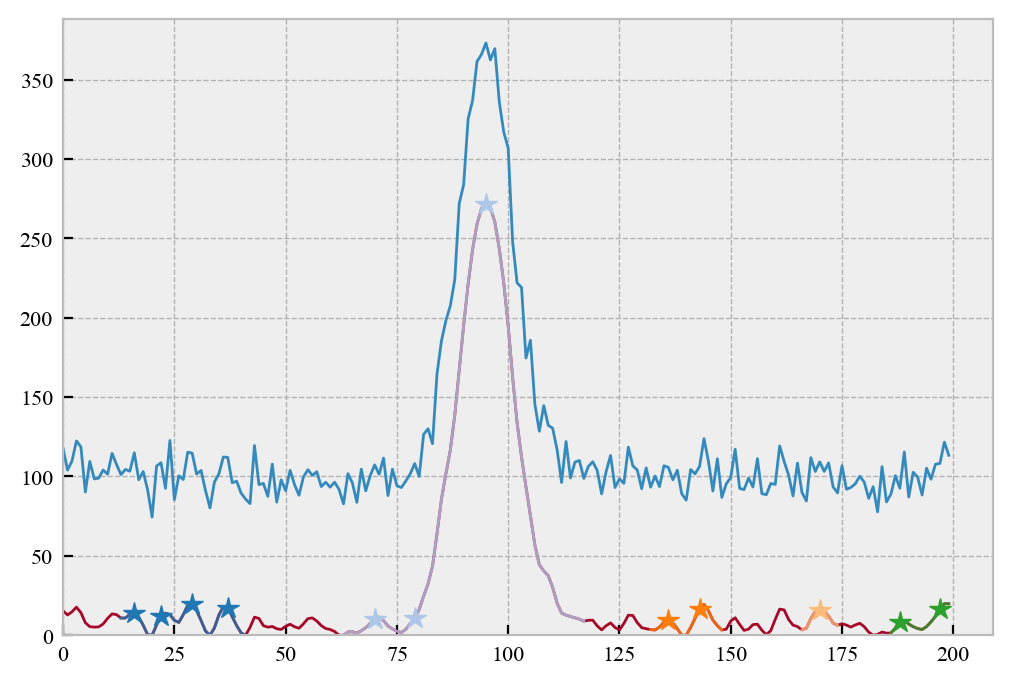

In [42]:
spectrum = pipenet.get_node(4).spectra[0]
# <peak location="95" FParea="3932.95" energy="95.00"/>

simulated.plot()
spectrum.plot()
spectrum.plot_regions()
spectrum.export_to_xml("results_example_2_pipenet.xml")

The calculate peak area is 3962, with relative error=0.7%.